In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

In [2]:
import IPython.display as ipd
import warnings
import os
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn.functional as F
from torch import optim,nn
from torchvision import datasets,models,transforms

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [4]:
data_dir = '/home/mds-student/Documents/aDITYA/multimodal-speech-emotion-recognition-master/IEMOCAP_image_data'
model_save_path = '/home/mds-student/Documents/aDITYA/multimodal-speech-emotion-recognition-master/save models/'
#train_dir = '/home/mds-student/Documents/aDITYA/multimodal-speech-emotion-recognition-master/IEMOCAP_train_dir/'
#train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
train_dir = '/home/mds-student/Documents/aDITYA/IEMOCAP/input/IEMOCAP_train_dir/'

In [5]:

train_transforms = transforms.Compose([transforms.Resize(256),
                                     #transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                     #transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])


In [6]:
trainset = datasets.ImageFolder(train_dir,transform= train_transforms)
testset = datasets.ImageFolder(test_dir,transform= test_transforms)

In [7]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=64)

In [8]:
print(len(trainloader.dataset))

3760


In [9]:
trainiter = iter(trainloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 256, 768]), torch.Size([64]))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
for param in model.parameters():
    param.requires_grad = False

In [13]:
classifier = nn.Sequential(nn.Linear(512, 200),
                           nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(200, 4))
model.fc = classifier

In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
anger = 0
happiness = 0
neutral = 0
sadness = 0

for _, target in trainloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])
    
for _, target in testloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])

In [16]:
sample_weights = [1/anger, 1/happiness, 1/neutral, 1/sadness]
class_weights = torch.FloatTensor(sample_weights).cpu()
class_weights

tensor([0.0009, 0.0009, 0.0009, 0.0009])

In [17]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
model = model.to(device)

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,279,916 total parameters.
103,404 training parameters.


In [20]:
labels = list(trainloader.dataset.class_to_idx.keys())
labels

['anger', 'happiness', 'neutral', 'sadness']

In [21]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 10}, fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.show()

In [22]:
label_to_class = {value: key for key, value in trainloader.dataset.class_to_idx.items()}
label_to_class

{0: 'anger', 1: 'happiness', 2: 'neutral', 3: 'sadness'}

In [23]:
def train(epoch, model):
    model.train()
    correct_train = 0
    train_loss = 0
    train_acc = 0
    
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
    
    return train_loss, int(train_acc.numpy())

In [24]:
def test(model):
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    pred_model = []
    actual = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)

        # output from model
        output = model(data)

        # sum total loss
        test_loss += criterion(output, target).item()

        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        pred_model.append(pred.cpu().numpy())
        actual.append(target.data.cpu().numpy())


    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


    pred_with_label = [label_to_class[label] for label in list(np.concatenate(pred_model))]
    actual_with_label = [label_to_class[label] for label in list(np.concatenate(actual))]

    plot_confusion_matrix(actual_with_label, pred_with_label, labels)

    print('\n Classification Report \n {} \n'.format(classification_report(actual_with_label, pred_with_label)))

    return test_loss, int(test_acc.numpy())

  0%|          | 0/59 [00:00<?, ?it/s]

Train Epoch: 1 [0/3760 (0%)]	Loss: 1.416637

Train Epoch: 1 [640/3760 (17%)]	Loss: 1.370468

Train Epoch: 1 [1280/3760 (34%)]	Loss: 1.372572

Train Epoch: 1 [1920/3760 (51%)]	Loss: 1.368205

Train Epoch: 1 [2560/3760 (68%)]	Loss: 1.386783

Train Epoch: 1 [3200/3760 (85%)]	Loss: 1.363622


Train set: Average loss: 0.0217


Train Accuracy: 1086/3760 (29%)


Test set: Average loss: 0.0213, Accuracy: 230/500 (46%)



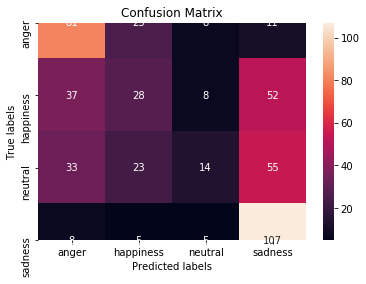

  2%|▏         | 1/59 [11:03<10:41:26, 663.56s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.51      0.65      0.57       125
   happiness       0.35      0.22      0.27       125
     neutral       0.40      0.11      0.18       125
     sadness       0.48      0.86      0.61       125

   micro avg       0.46      0.46      0.46       500
   macro avg       0.43      0.46      0.41       500
weighted avg       0.43      0.46      0.41       500
 

Train Epoch: 2 [0/3760 (0%)]	Loss: 1.315182

Train Epoch: 2 [640/3760 (17%)]	Loss: 1.378893

Train Epoch: 2 [1280/3760 (34%)]	Loss: 1.291154

Train Epoch: 2 [1920/3760 (51%)]	Loss: 1.318127

Train Epoch: 2 [2560/3760 (68%)]	Loss: 1.302064

Train Epoch: 2 [3200/3760 (85%)]	Loss: 1.338090


Train set: Average loss: 0.0209


Train Accuracy: 1340/3760 (36%)


Test set: Average loss: 0.0207, Accuracy: 231/500 (46%)



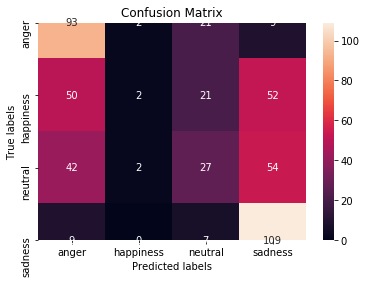

  3%|▎         | 2/59 [19:42<9:49:07, 620.14s/it] 


 Classification Report 
               precision    recall  f1-score   support

       anger       0.48      0.74      0.58       125
   happiness       0.33      0.02      0.03       125
     neutral       0.36      0.22      0.27       125
     sadness       0.49      0.87      0.62       125

   micro avg       0.46      0.46      0.46       500
   macro avg       0.41      0.46      0.38       500
weighted avg       0.41      0.46      0.38       500
 

Train Epoch: 3 [0/3760 (0%)]	Loss: 1.323414

Train Epoch: 3 [640/3760 (17%)]	Loss: 1.333149

Train Epoch: 3 [1280/3760 (34%)]	Loss: 1.286249

Train Epoch: 3 [1920/3760 (51%)]	Loss: 1.297229

Train Epoch: 3 [2560/3760 (68%)]	Loss: 1.315616

Train Epoch: 3 [3200/3760 (85%)]	Loss: 1.301690


Train set: Average loss: 0.0204


Train Accuracy: 1515/3760 (40%)


Test set: Average loss: 0.0201, Accuracy: 245/500 (49%)



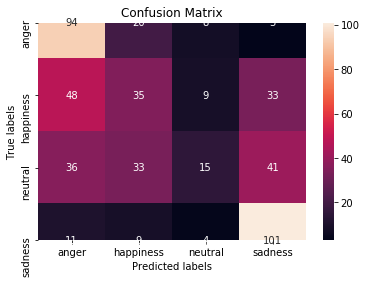

  5%|▌         | 3/59 [27:57<9:03:47, 582.63s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.75      0.60       125
   happiness       0.36      0.28      0.32       125
     neutral       0.42      0.12      0.19       125
     sadness       0.57      0.81      0.67       125

   micro avg       0.49      0.49      0.49       500
   macro avg       0.46      0.49      0.44       500
weighted avg       0.46      0.49      0.44       500
 

Train Epoch: 4 [0/3760 (0%)]	Loss: 1.271298

Train Epoch: 4 [640/3760 (17%)]	Loss: 1.285581

Train Epoch: 4 [1280/3760 (34%)]	Loss: 1.231070

Train Epoch: 4 [1920/3760 (51%)]	Loss: 1.311746

Train Epoch: 4 [2560/3760 (68%)]	Loss: 1.252422

Train Epoch: 4 [3200/3760 (85%)]	Loss: 1.290219


Train set: Average loss: 0.0200


Train Accuracy: 1596/3760 (42%)


Test set: Average loss: 0.0197, Accuracy: 254/500 (51%)



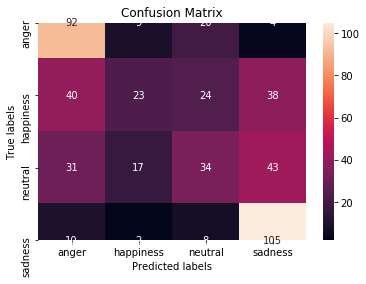

  7%|▋         | 4/59 [36:13<8:30:23, 556.79s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.74      0.62       125
   happiness       0.45      0.18      0.26       125
     neutral       0.40      0.27      0.32       125
     sadness       0.55      0.84      0.67       125

   micro avg       0.51      0.51      0.51       500
   macro avg       0.48      0.51      0.47       500
weighted avg       0.48      0.51      0.47       500
 

Train Epoch: 5 [0/3760 (0%)]	Loss: 1.349523

Train Epoch: 5 [640/3760 (17%)]	Loss: 1.241291

Train Epoch: 5 [1280/3760 (34%)]	Loss: 1.259103

Train Epoch: 5 [1920/3760 (51%)]	Loss: 1.256552

Train Epoch: 5 [2560/3760 (68%)]	Loss: 1.231138

Train Epoch: 5 [3200/3760 (85%)]	Loss: 1.244215


Train set: Average loss: 0.0197


Train Accuracy: 1668/3760 (44%)


Test set: Average loss: 0.0193, Accuracy: 246/500 (49%)



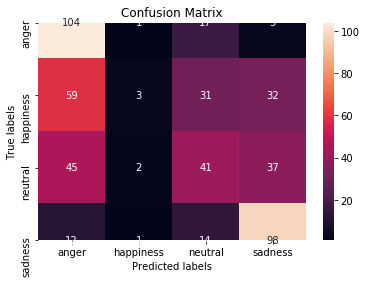

  8%|▊         | 5/59 [44:31<8:04:58, 538.87s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.47      0.83      0.60       125
   happiness       0.43      0.02      0.05       125
     neutral       0.40      0.33      0.36       125
     sadness       0.58      0.78      0.66       125

   micro avg       0.49      0.49      0.49       500
   macro avg       0.47      0.49      0.42       500
weighted avg       0.47      0.49      0.42       500
 

Train Epoch: 6 [0/3760 (0%)]	Loss: 1.196345

Train Epoch: 6 [640/3760 (17%)]	Loss: 1.271724

Train Epoch: 6 [1280/3760 (34%)]	Loss: 1.262426

Train Epoch: 6 [1920/3760 (51%)]	Loss: 1.204387

Train Epoch: 6 [2560/3760 (68%)]	Loss: 1.264452

Train Epoch: 6 [3200/3760 (85%)]	Loss: 1.241545


Train set: Average loss: 0.0192


Train Accuracy: 1724/3760 (46%)


Test set: Average loss: 0.0189, Accuracy: 262/500 (52%)



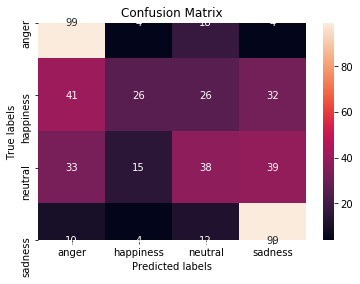

 10%|█         | 6/59 [52:48<7:44:57, 526.38s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.54      0.79      0.64       125
   happiness       0.53      0.21      0.30       125
     neutral       0.40      0.30      0.35       125
     sadness       0.57      0.79      0.66       125

   micro avg       0.52      0.52      0.52       500
   macro avg       0.51      0.52      0.49       500
weighted avg       0.51      0.52      0.49       500
 

Train Epoch: 7 [0/3760 (0%)]	Loss: 1.243175

Train Epoch: 7 [640/3760 (17%)]	Loss: 1.151892

Train Epoch: 7 [1280/3760 (34%)]	Loss: 1.253678

Train Epoch: 7 [1920/3760 (51%)]	Loss: 1.195465

Train Epoch: 7 [2560/3760 (68%)]	Loss: 1.178209

Train Epoch: 7 [3200/3760 (85%)]	Loss: 1.146687


Train set: Average loss: 0.0188


Train Accuracy: 1788/3760 (48%)


Test set: Average loss: 0.0186, Accuracy: 254/500 (51%)



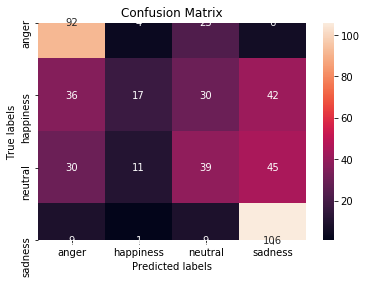

 12%|█▏        | 7/59 [1:01:05<7:28:35, 517.62s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.74      0.63       125
   happiness       0.52      0.14      0.22       125
     neutral       0.39      0.31      0.35       125
     sadness       0.53      0.85      0.65       125

   micro avg       0.51      0.51      0.51       500
   macro avg       0.50      0.51      0.46       500
weighted avg       0.50      0.51      0.46       500
 

Train Epoch: 8 [0/3760 (0%)]	Loss: 1.248430

Train Epoch: 8 [640/3760 (17%)]	Loss: 1.215441

Train Epoch: 8 [1280/3760 (34%)]	Loss: 1.221480

Train Epoch: 8 [1920/3760 (51%)]	Loss: 1.118942

Train Epoch: 8 [2560/3760 (68%)]	Loss: 1.210933

Train Epoch: 8 [3200/3760 (85%)]	Loss: 1.216581


Train set: Average loss: 0.0185


Train Accuracy: 1776/3760 (47%)


Test set: Average loss: 0.0184, Accuracy: 257/500 (51%)



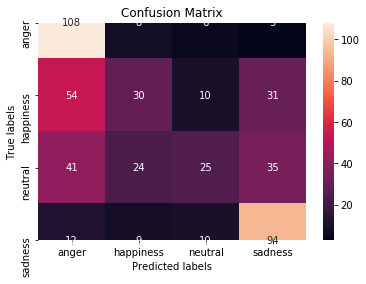

 14%|█▎        | 8/59 [1:09:22<7:14:42, 511.41s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.86      0.64       125
   happiness       0.42      0.24      0.31       125
     neutral       0.49      0.20      0.28       125
     sadness       0.58      0.75      0.65       125

   micro avg       0.51      0.51      0.51       500
   macro avg       0.50      0.51      0.47       500
weighted avg       0.50      0.51      0.47       500
 

Train Epoch: 9 [0/3760 (0%)]	Loss: 1.119548

Train Epoch: 9 [640/3760 (17%)]	Loss: 1.169510

Train Epoch: 9 [1280/3760 (34%)]	Loss: 1.190769

Train Epoch: 9 [1920/3760 (51%)]	Loss: 1.223703

Train Epoch: 9 [2560/3760 (68%)]	Loss: 1.101617

Train Epoch: 9 [3200/3760 (85%)]	Loss: 1.165642


Train set: Average loss: 0.0184


Train Accuracy: 1809/3760 (48%)


Test set: Average loss: 0.0181, Accuracy: 267/500 (53%)



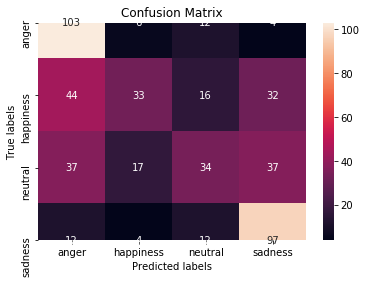

 15%|█▌        | 9/59 [1:17:38<7:02:25, 506.92s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.82      0.64       125
   happiness       0.55      0.26      0.36       125
     neutral       0.46      0.27      0.34       125
     sadness       0.57      0.78      0.66       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.53      0.53      0.50       500
weighted avg       0.53      0.53      0.50       500
 

Train Epoch: 10 [0/3760 (0%)]	Loss: 1.226616

Train Epoch: 10 [640/3760 (17%)]	Loss: 1.187171

Train Epoch: 10 [1280/3760 (34%)]	Loss: 1.205749

Train Epoch: 10 [1920/3760 (51%)]	Loss: 1.112160

Train Epoch: 10 [2560/3760 (68%)]	Loss: 1.230641

Train Epoch: 10 [3200/3760 (85%)]	Loss: 1.235452


Train set: Average loss: 0.0182


Train Accuracy: 1817/3760 (48%)


Test set: Average loss: 0.0180, Accuracy: 264/500 (53%)



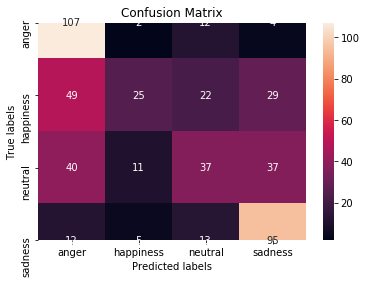

 17%|█▋        | 10/59 [1:25:55<6:51:29, 503.87s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.51      0.86      0.64       125
   happiness       0.58      0.20      0.30       125
     neutral       0.44      0.30      0.35       125
     sadness       0.58      0.76      0.66       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.53      0.53      0.49       500
weighted avg       0.53      0.53      0.49       500
 

Train Epoch: 11 [0/3760 (0%)]	Loss: 1.097093

Train Epoch: 11 [640/3760 (17%)]	Loss: 1.139321

Train Epoch: 11 [1280/3760 (34%)]	Loss: 1.221331

Train Epoch: 11 [1920/3760 (51%)]	Loss: 1.072935

Train Epoch: 11 [2560/3760 (68%)]	Loss: 1.042907

Train Epoch: 11 [3200/3760 (85%)]	Loss: 1.131395


Train set: Average loss: 0.0180


Train Accuracy: 1859/3760 (49%)


Test set: Average loss: 0.0177, Accuracy: 274/500 (55%)



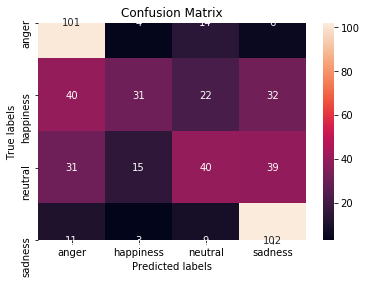

 19%|█▊        | 11/59 [1:34:12<6:41:29, 501.86s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.81      0.66       125
   happiness       0.58      0.25      0.35       125
     neutral       0.47      0.32      0.38       125
     sadness       0.57      0.82      0.67       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.51       500
weighted avg       0.54      0.55      0.51       500
 

Train Epoch: 12 [0/3760 (0%)]	Loss: 1.200329

Train Epoch: 12 [640/3760 (17%)]	Loss: 1.201865

Train Epoch: 12 [1280/3760 (34%)]	Loss: 1.067305

Train Epoch: 12 [1920/3760 (51%)]	Loss: 1.159426

Train Epoch: 12 [2560/3760 (68%)]	Loss: 1.109874

Train Epoch: 12 [3200/3760 (85%)]	Loss: 1.115603


Train set: Average loss: 0.0180


Train Accuracy: 1874/3760 (50%)


Test set: Average loss: 0.0176, Accuracy: 275/500 (55%)



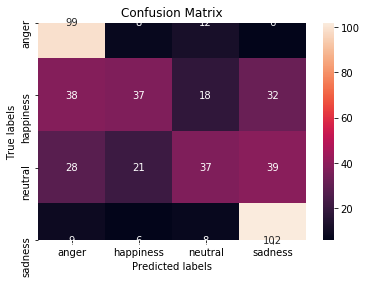

 20%|██        | 12/59 [1:42:29<6:31:57, 500.37s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.79      0.66       125
   happiness       0.51      0.30      0.38       125
     neutral       0.49      0.30      0.37       125
     sadness       0.57      0.82      0.67       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.52       500
weighted avg       0.54      0.55      0.52       500
 

Train Epoch: 13 [0/3760 (0%)]	Loss: 1.140165

Train Epoch: 13 [640/3760 (17%)]	Loss: 1.191080

Train Epoch: 13 [1280/3760 (34%)]	Loss: 1.110832

Train Epoch: 13 [1920/3760 (51%)]	Loss: 1.152572

Train Epoch: 13 [2560/3760 (68%)]	Loss: 1.087079

Train Epoch: 13 [3200/3760 (85%)]	Loss: 1.196706


Train set: Average loss: 0.0177


Train Accuracy: 1903/3760 (51%)


Test set: Average loss: 0.0175, Accuracy: 271/500 (54%)



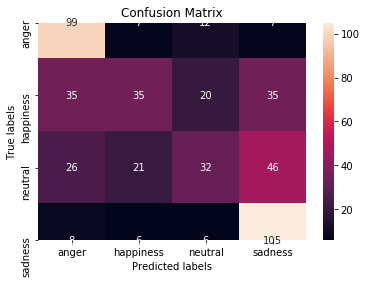

 22%|██▏       | 13/59 [1:50:46<6:22:44, 499.22s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.79      0.68       125
   happiness       0.51      0.28      0.36       125
     neutral       0.46      0.26      0.33       125
     sadness       0.54      0.84      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.51       500
weighted avg       0.52      0.54      0.51       500
 

Train Epoch: 14 [0/3760 (0%)]	Loss: 1.087485

Train Epoch: 14 [640/3760 (17%)]	Loss: 1.066752

Train Epoch: 14 [1280/3760 (34%)]	Loss: 1.109028

Train Epoch: 14 [1920/3760 (51%)]	Loss: 1.192147

Train Epoch: 14 [2560/3760 (68%)]	Loss: 1.109661

Train Epoch: 14 [3200/3760 (85%)]	Loss: 1.123590


Train set: Average loss: 0.0176


Train Accuracy: 1932/3760 (51%)


Test set: Average loss: 0.0174, Accuracy: 273/500 (55%)



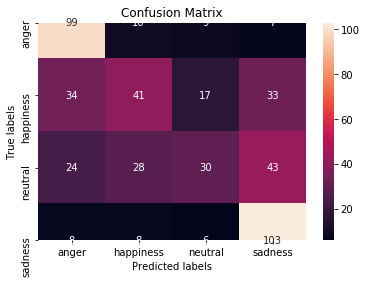

 24%|██▎       | 14/59 [1:59:03<6:13:54, 498.54s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.79      0.68       125
   happiness       0.47      0.33      0.39       125
     neutral       0.48      0.24      0.32       125
     sadness       0.55      0.82      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.53      0.55      0.51       500
weighted avg       0.53      0.55      0.51       500
 

Train Epoch: 15 [0/3760 (0%)]	Loss: 1.011475

Train Epoch: 15 [640/3760 (17%)]	Loss: 1.114606

Train Epoch: 15 [1280/3760 (34%)]	Loss: 1.152129

Train Epoch: 15 [1920/3760 (51%)]	Loss: 1.133667

Train Epoch: 15 [2560/3760 (68%)]	Loss: 1.100963

Train Epoch: 15 [3200/3760 (85%)]	Loss: 1.147002


Train set: Average loss: 0.0174


Train Accuracy: 1963/3760 (52%)


Test set: Average loss: 0.0173, Accuracy: 260/500 (52%)



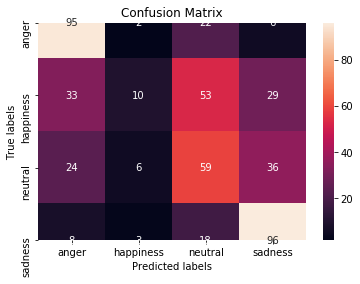

 25%|██▌       | 15/59 [2:07:20<6:05:17, 498.12s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.76      0.67       125
   happiness       0.48      0.08      0.14       125
     neutral       0.39      0.47      0.43       125
     sadness       0.57      0.77      0.66       125

   micro avg       0.52      0.52      0.52       500
   macro avg       0.51      0.52      0.47       500
weighted avg       0.51      0.52      0.47       500
 

Train Epoch: 16 [0/3760 (0%)]	Loss: 1.157106

Train Epoch: 16 [640/3760 (17%)]	Loss: 1.110255

Train Epoch: 16 [1280/3760 (34%)]	Loss: 1.099787

Train Epoch: 16 [1920/3760 (51%)]	Loss: 1.160805

Train Epoch: 16 [2560/3760 (68%)]	Loss: 1.189922

Train Epoch: 16 [3200/3760 (85%)]	Loss: 1.026474


Train set: Average loss: 0.0174


Train Accuracy: 1934/3760 (51%)


Test set: Average loss: 0.0172, Accuracy: 277/500 (55%)



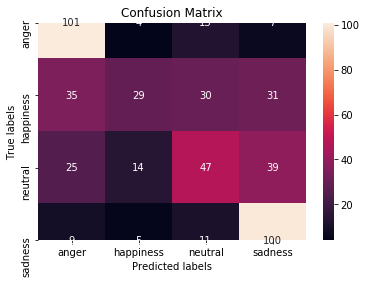

 27%|██▋       | 16/59 [2:15:37<5:56:41, 497.72s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.81      0.68       125
   happiness       0.56      0.23      0.33       125
     neutral       0.47      0.38      0.42       125
     sadness       0.56      0.80      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.55      0.55      0.52       500
weighted avg       0.55      0.55      0.52       500
 

Train Epoch: 17 [0/3760 (0%)]	Loss: 1.107149

Train Epoch: 17 [640/3760 (17%)]	Loss: 1.187442

Train Epoch: 17 [1280/3760 (34%)]	Loss: 1.092977

Train Epoch: 17 [1920/3760 (51%)]	Loss: 1.062702

Train Epoch: 17 [2560/3760 (68%)]	Loss: 1.078391

Train Epoch: 17 [3200/3760 (85%)]	Loss: 1.197034


Train set: Average loss: 0.0173


Train Accuracy: 1970/3760 (52%)


Test set: Average loss: 0.0172, Accuracy: 277/500 (55%)



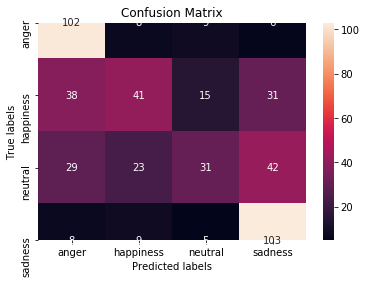

 29%|██▉       | 17/59 [2:23:53<5:48:12, 497.44s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.82      0.68       125
   happiness       0.51      0.33      0.40       125
     neutral       0.52      0.25      0.34       125
     sadness       0.57      0.82      0.67       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.52       500
weighted avg       0.54      0.55      0.52       500
 

Train Epoch: 18 [0/3760 (0%)]	Loss: 1.045493

Train Epoch: 18 [640/3760 (17%)]	Loss: 1.250637

Train Epoch: 18 [1280/3760 (34%)]	Loss: 1.124019

Train Epoch: 18 [1920/3760 (51%)]	Loss: 1.176789

Train Epoch: 18 [2560/3760 (68%)]	Loss: 1.082399

Train Epoch: 18 [3200/3760 (85%)]	Loss: 1.024089


Train set: Average loss: 0.0171


Train Accuracy: 1984/3760 (53%)


Test set: Average loss: 0.0171, Accuracy: 269/500 (54%)



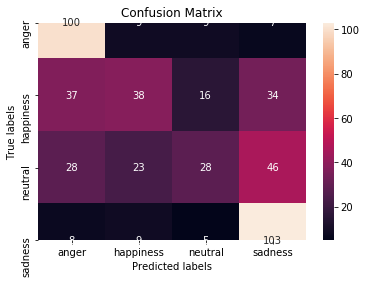

 31%|███       | 18/59 [2:32:11<5:39:54, 497.42s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.80      0.67       125
   happiness       0.48      0.30      0.37       125
     neutral       0.48      0.22      0.31       125
     sadness       0.54      0.82      0.65       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.50       500
weighted avg       0.52      0.54      0.50       500
 

Train Epoch: 19 [0/3760 (0%)]	Loss: 1.186868

Train Epoch: 19 [640/3760 (17%)]	Loss: 1.073469

Train Epoch: 19 [1280/3760 (34%)]	Loss: 0.935857

Train Epoch: 19 [1920/3760 (51%)]	Loss: 1.110129

Train Epoch: 19 [2560/3760 (68%)]	Loss: 1.191756

Train Epoch: 19 [3200/3760 (85%)]	Loss: 1.111286


Train set: Average loss: 0.0171


Train Accuracy: 2005/3760 (53%)


Test set: Average loss: 0.0171, Accuracy: 269/500 (54%)



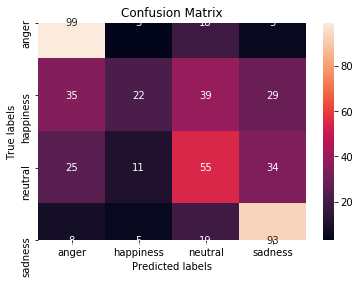

 32%|███▏      | 19/59 [2:40:28<5:31:30, 497.25s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.79      0.68       125
   happiness       0.54      0.18      0.27       125
     neutral       0.42      0.44      0.43       125
     sadness       0.58      0.74      0.65       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.53      0.54      0.51       500
weighted avg       0.53      0.54      0.51       500
 

Train Epoch: 20 [0/3760 (0%)]	Loss: 1.177321

Train Epoch: 20 [640/3760 (17%)]	Loss: 1.212770

Train Epoch: 20 [1280/3760 (34%)]	Loss: 1.082978

Train Epoch: 20 [1920/3760 (51%)]	Loss: 1.187782

Train Epoch: 20 [2560/3760 (68%)]	Loss: 1.205628

Train Epoch: 20 [3200/3760 (85%)]	Loss: 1.035757


Train set: Average loss: 0.0171


Train Accuracy: 1964/3760 (52%)


Test set: Average loss: 0.0170, Accuracy: 270/500 (54%)



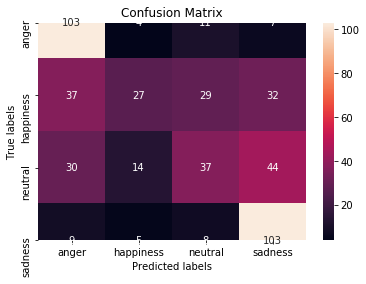

 34%|███▍      | 20/59 [2:48:44<5:23:08, 497.15s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.82      0.68       125
   happiness       0.54      0.22      0.31       125
     neutral       0.44      0.30      0.35       125
     sadness       0.55      0.82      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.53      0.54      0.50       500
weighted avg       0.53      0.54      0.50       500
 

Train Epoch: 21 [0/3760 (0%)]	Loss: 1.020341

Train Epoch: 21 [640/3760 (17%)]	Loss: 1.067574

Train Epoch: 21 [1280/3760 (34%)]	Loss: 1.054877

Train Epoch: 21 [1920/3760 (51%)]	Loss: 1.032079

Train Epoch: 21 [2560/3760 (68%)]	Loss: 1.121561

Train Epoch: 21 [3200/3760 (85%)]	Loss: 0.940247


Train set: Average loss: 0.0169


Train Accuracy: 2000/3760 (53%)


Test set: Average loss: 0.0170, Accuracy: 270/500 (54%)



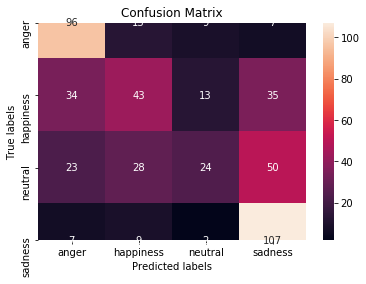

 36%|███▌      | 21/59 [2:57:01<5:14:46, 497.01s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.77      0.67       125
   happiness       0.46      0.34      0.39       125
     neutral       0.50      0.19      0.28       125
     sadness       0.54      0.86      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.53      0.54      0.50       500
weighted avg       0.53      0.54      0.50       500
 

Train Epoch: 22 [0/3760 (0%)]	Loss: 1.087444

Train Epoch: 22 [640/3760 (17%)]	Loss: 1.192356

Train Epoch: 22 [1280/3760 (34%)]	Loss: 0.991055

Train Epoch: 22 [1920/3760 (51%)]	Loss: 1.032928

Train Epoch: 22 [2560/3760 (68%)]	Loss: 1.025838

Train Epoch: 22 [3200/3760 (85%)]	Loss: 1.113438


Train set: Average loss: 0.0169


Train Accuracy: 1976/3760 (53%)


Test set: Average loss: 0.0168, Accuracy: 264/500 (53%)



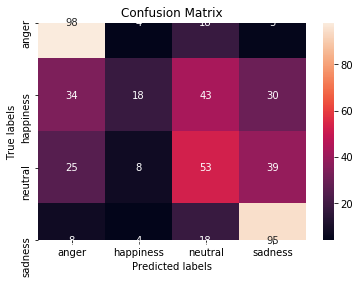

 37%|███▋      | 22/59 [3:05:18<5:06:25, 496.91s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.78      0.68       125
   happiness       0.53      0.14      0.23       125
     neutral       0.40      0.42      0.41       125
     sadness       0.56      0.76      0.65       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.52      0.53      0.49       500
weighted avg       0.52      0.53      0.49       500
 

Train Epoch: 23 [0/3760 (0%)]	Loss: 1.139601

Train Epoch: 23 [640/3760 (17%)]	Loss: 1.087415

Train Epoch: 23 [1280/3760 (34%)]	Loss: 1.117302

Train Epoch: 23 [1920/3760 (51%)]	Loss: 0.972526

Train Epoch: 23 [2560/3760 (68%)]	Loss: 1.052569

Train Epoch: 23 [3200/3760 (85%)]	Loss: 1.064833


Train set: Average loss: 0.0169


Train Accuracy: 2013/3760 (54%)


Test set: Average loss: 0.0167, Accuracy: 273/500 (55%)



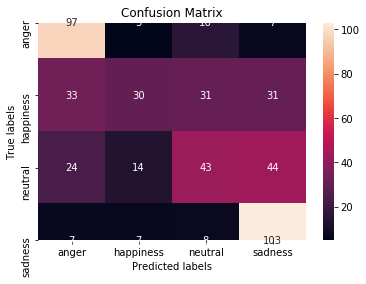

 39%|███▉      | 23/59 [3:13:35<4:58:08, 496.90s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.60      0.78      0.68       125
   happiness       0.54      0.24      0.33       125
     neutral       0.44      0.34      0.39       125
     sadness       0.56      0.82      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.53      0.55      0.51       500
weighted avg       0.53      0.55      0.51       500
 

Train Epoch: 24 [0/3760 (0%)]	Loss: 0.911841

Train Epoch: 24 [640/3760 (17%)]	Loss: 1.133666

Train Epoch: 24 [1280/3760 (34%)]	Loss: 0.974096

Train Epoch: 24 [1920/3760 (51%)]	Loss: 1.105048

Train Epoch: 24 [2560/3760 (68%)]	Loss: 1.032108

Train Epoch: 24 [3200/3760 (85%)]	Loss: 1.124607


Train set: Average loss: 0.0168


Train Accuracy: 2038/3760 (54%)


Test set: Average loss: 0.0168, Accuracy: 271/500 (54%)



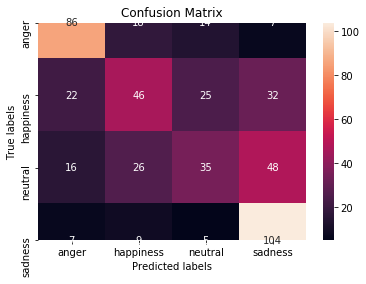

 41%|████      | 24/59 [3:21:52<4:49:52, 496.92s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.69      0.67       125
   happiness       0.46      0.37      0.41       125
     neutral       0.44      0.28      0.34       125
     sadness       0.54      0.83      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.53      0.54      0.52       500
weighted avg       0.53      0.54      0.52       500
 

Train Epoch: 25 [0/3760 (0%)]	Loss: 0.969945

Train Epoch: 25 [640/3760 (17%)]	Loss: 1.078093

Train Epoch: 25 [1280/3760 (34%)]	Loss: 1.151551

Train Epoch: 25 [1920/3760 (51%)]	Loss: 1.121172

Train Epoch: 25 [2560/3760 (68%)]	Loss: 1.034054

Train Epoch: 25 [3200/3760 (85%)]	Loss: 1.091848


Train set: Average loss: 0.0169


Train Accuracy: 2009/3760 (53%)


Test set: Average loss: 0.0167, Accuracy: 270/500 (54%)



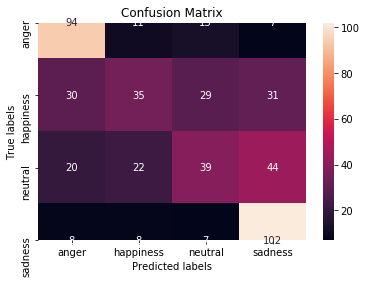

 42%|████▏     | 25/59 [3:30:09<4:41:38, 497.01s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.75      0.68       125
   happiness       0.46      0.28      0.35       125
     neutral       0.44      0.31      0.37       125
     sadness       0.55      0.82      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.51       500
weighted avg       0.52      0.54      0.51       500
 

Train Epoch: 26 [0/3760 (0%)]	Loss: 1.113459

Train Epoch: 26 [640/3760 (17%)]	Loss: 1.007228

Train Epoch: 26 [1280/3760 (34%)]	Loss: 1.083306

Train Epoch: 26 [1920/3760 (51%)]	Loss: 1.084247

Train Epoch: 26 [2560/3760 (68%)]	Loss: 1.033498

Train Epoch: 26 [3200/3760 (85%)]	Loss: 1.073001


Train set: Average loss: 0.0166


Train Accuracy: 2043/3760 (54%)


Test set: Average loss: 0.0166, Accuracy: 277/500 (55%)



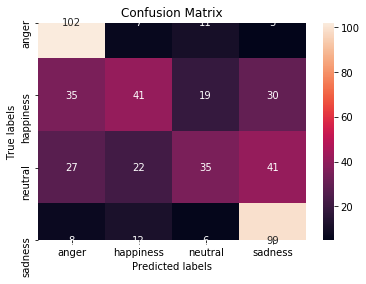

 44%|████▍     | 26/59 [3:38:26<4:33:20, 496.99s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.82      0.69       125
   happiness       0.50      0.33      0.40       125
     neutral       0.49      0.28      0.36       125
     sadness       0.57      0.79      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.53       500
weighted avg       0.54      0.55      0.53       500
 

Train Epoch: 27 [0/3760 (0%)]	Loss: 1.029311

Train Epoch: 27 [640/3760 (17%)]	Loss: 1.091472

Train Epoch: 27 [1280/3760 (34%)]	Loss: 1.029154

Train Epoch: 27 [1920/3760 (51%)]	Loss: 0.937399

Train Epoch: 27 [2560/3760 (68%)]	Loss: 1.085101

Train Epoch: 27 [3200/3760 (85%)]	Loss: 1.052549


Train set: Average loss: 0.0166


Train Accuracy: 2059/3760 (55%)


Test set: Average loss: 0.0166, Accuracy: 270/500 (54%)



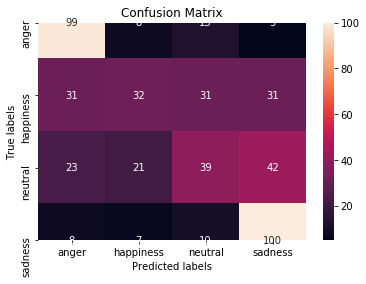

 46%|████▌     | 27/59 [3:46:42<4:24:58, 496.83s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.79      0.69       125
   happiness       0.47      0.26      0.33       125
     neutral       0.42      0.31      0.36       125
     sadness       0.56      0.80      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.51       500
weighted avg       0.52      0.54      0.51       500
 

Train Epoch: 28 [0/3760 (0%)]	Loss: 1.020342

Train Epoch: 28 [640/3760 (17%)]	Loss: 1.068780

Train Epoch: 28 [1280/3760 (34%)]	Loss: 1.009329

Train Epoch: 28 [1920/3760 (51%)]	Loss: 0.939144

Train Epoch: 28 [2560/3760 (68%)]	Loss: 1.075716

Train Epoch: 28 [3200/3760 (85%)]	Loss: 0.988823


Train set: Average loss: 0.0165


Train Accuracy: 2047/3760 (54%)


Test set: Average loss: 0.0166, Accuracy: 270/500 (54%)



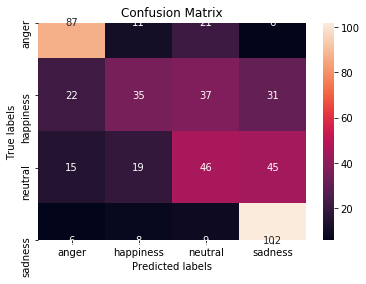

 47%|████▋     | 28/59 [3:54:59<4:16:41, 496.82s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.67      0.70      0.68       125
   happiness       0.48      0.28      0.35       125
     neutral       0.41      0.37      0.39       125
     sadness       0.55      0.82      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.53      0.54      0.52       500
weighted avg       0.53      0.54      0.52       500
 

Train Epoch: 29 [0/3760 (0%)]	Loss: 1.069655

Train Epoch: 29 [640/3760 (17%)]	Loss: 1.092394

Train Epoch: 29 [1280/3760 (34%)]	Loss: 1.113479

Train Epoch: 29 [1920/3760 (51%)]	Loss: 1.076683

Train Epoch: 29 [2560/3760 (68%)]	Loss: 1.086950

Train Epoch: 29 [3200/3760 (85%)]	Loss: 1.110828


Train set: Average loss: 0.0165


Train Accuracy: 2088/3760 (56%)


Test set: Average loss: 0.0165, Accuracy: 272/500 (54%)



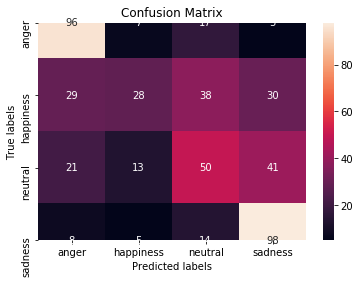

 49%|████▉     | 29/59 [4:03:16<4:08:25, 496.86s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.77      0.69       125
   happiness       0.53      0.22      0.31       125
     neutral       0.42      0.40      0.41       125
     sadness       0.56      0.78      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.53      0.54      0.52       500
weighted avg       0.53      0.54      0.52       500
 

Train Epoch: 30 [0/3760 (0%)]	Loss: 1.087077

Train Epoch: 30 [640/3760 (17%)]	Loss: 1.043104

Train Epoch: 30 [1280/3760 (34%)]	Loss: 0.989282

Train Epoch: 30 [1920/3760 (51%)]	Loss: 0.969159

Train Epoch: 30 [2560/3760 (68%)]	Loss: 1.020849

Train Epoch: 30 [3200/3760 (85%)]	Loss: 1.067684


Train set: Average loss: 0.0163


Train Accuracy: 2079/3760 (55%)


Test set: Average loss: 0.0165, Accuracy: 271/500 (54%)



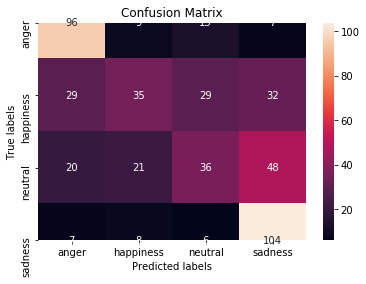

 51%|█████     | 30/59 [4:11:33<4:00:11, 496.94s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.77      0.69       125
   happiness       0.48      0.28      0.35       125
     neutral       0.43      0.29      0.34       125
     sadness       0.54      0.83      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.51       500
weighted avg       0.52      0.54      0.51       500
 

Train Epoch: 31 [0/3760 (0%)]	Loss: 1.049654

Train Epoch: 31 [640/3760 (17%)]	Loss: 1.015914

Train Epoch: 31 [1280/3760 (34%)]	Loss: 1.105620

Train Epoch: 31 [1920/3760 (51%)]	Loss: 1.043430

Train Epoch: 31 [2560/3760 (68%)]	Loss: 1.066965

Train Epoch: 31 [3200/3760 (85%)]	Loss: 1.022661


Train set: Average loss: 0.0164


Train Accuracy: 2058/3760 (55%)


Test set: Average loss: 0.0164, Accuracy: 271/500 (54%)



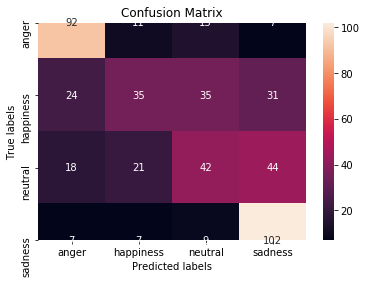

 53%|█████▎    | 31/59 [4:19:50<3:51:55, 496.97s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.74      0.69       125
   happiness       0.47      0.28      0.35       125
     neutral       0.42      0.34      0.37       125
     sadness       0.55      0.82      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.52       500
weighted avg       0.52      0.54      0.52       500
 

Train Epoch: 32 [0/3760 (0%)]	Loss: 0.992720

Train Epoch: 32 [640/3760 (17%)]	Loss: 1.031167

Train Epoch: 32 [1280/3760 (34%)]	Loss: 1.144473

Train Epoch: 32 [1920/3760 (51%)]	Loss: 1.093451

Train Epoch: 32 [2560/3760 (68%)]	Loss: 0.961071

Train Epoch: 32 [3200/3760 (85%)]	Loss: 1.236821


Train set: Average loss: 0.0163


Train Accuracy: 2126/3760 (57%)


Test set: Average loss: 0.0164, Accuracy: 274/500 (55%)



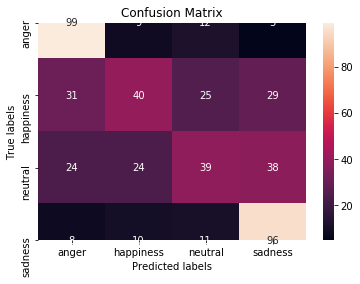

 54%|█████▍    | 32/59 [4:28:07<3:43:40, 497.06s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.79      0.69       125
   happiness       0.48      0.32      0.38       125
     neutral       0.45      0.31      0.37       125
     sadness       0.57      0.77      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.53      0.55      0.52       500
weighted avg       0.53      0.55      0.52       500
 

Train Epoch: 33 [0/3760 (0%)]	Loss: 0.999681

Train Epoch: 33 [640/3760 (17%)]	Loss: 1.110755

Train Epoch: 33 [1280/3760 (34%)]	Loss: 1.097280

Train Epoch: 33 [1920/3760 (51%)]	Loss: 1.172635

Train Epoch: 33 [2560/3760 (68%)]	Loss: 0.907928

Train Epoch: 33 [3200/3760 (85%)]	Loss: 1.014967


Train set: Average loss: 0.0162


Train Accuracy: 2079/3760 (55%)


Test set: Average loss: 0.0164, Accuracy: 273/500 (55%)



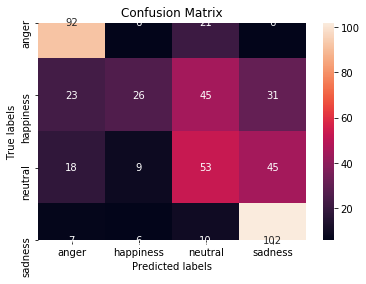

 56%|█████▌    | 33/59 [4:36:25<3:35:23, 497.07s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.74      0.69       125
   happiness       0.55      0.21      0.30       125
     neutral       0.41      0.42      0.42       125
     sadness       0.55      0.82      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.52       500
weighted avg       0.54      0.55      0.52       500
 

Train Epoch: 34 [0/3760 (0%)]	Loss: 1.023829

Train Epoch: 34 [640/3760 (17%)]	Loss: 0.992787

Train Epoch: 34 [1280/3760 (34%)]	Loss: 1.051147

Train Epoch: 34 [1920/3760 (51%)]	Loss: 1.044373

Train Epoch: 34 [2560/3760 (68%)]	Loss: 1.014173

Train Epoch: 34 [3200/3760 (85%)]	Loss: 1.015451


Train set: Average loss: 0.0163


Train Accuracy: 2111/3760 (56%)


Test set: Average loss: 0.0165, Accuracy: 271/500 (54%)



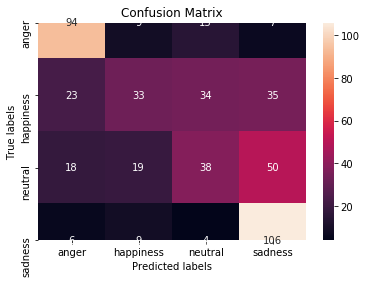

 58%|█████▊    | 34/59 [4:44:42<3:27:07, 497.11s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.67      0.75      0.71       125
   happiness       0.47      0.26      0.34       125
     neutral       0.42      0.30      0.35       125
     sadness       0.54      0.85      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.51       500
weighted avg       0.52      0.54      0.51       500
 

Train Epoch: 35 [0/3760 (0%)]	Loss: 1.167589

Train Epoch: 35 [640/3760 (17%)]	Loss: 1.140348

Train Epoch: 35 [1280/3760 (34%)]	Loss: 0.975466

Train Epoch: 35 [1920/3760 (51%)]	Loss: 1.109986

Train Epoch: 35 [2560/3760 (68%)]	Loss: 0.954360

Train Epoch: 35 [3200/3760 (85%)]	Loss: 0.891549


Train set: Average loss: 0.0162


Train Accuracy: 2091/3760 (56%)


Test set: Average loss: 0.0164, Accuracy: 275/500 (55%)



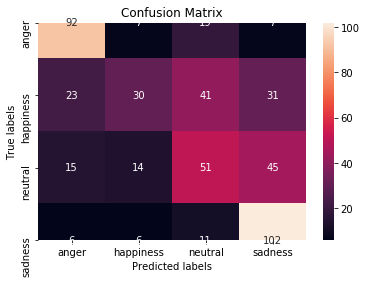

 59%|█████▉    | 35/59 [4:52:59<3:18:48, 497.04s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.74      0.70       125
   happiness       0.53      0.24      0.33       125
     neutral       0.42      0.41      0.41       125
     sadness       0.55      0.82      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.53       500
weighted avg       0.54      0.55      0.53       500
 

Train Epoch: 36 [0/3760 (0%)]	Loss: 1.090957

Train Epoch: 36 [640/3760 (17%)]	Loss: 0.975489

Train Epoch: 36 [1280/3760 (34%)]	Loss: 1.011796

Train Epoch: 36 [1920/3760 (51%)]	Loss: 1.052027

Train Epoch: 36 [2560/3760 (68%)]	Loss: 1.078293

Train Epoch: 36 [3200/3760 (85%)]	Loss: 1.085062


Train set: Average loss: 0.0161


Train Accuracy: 2101/3760 (56%)


Test set: Average loss: 0.0163, Accuracy: 276/500 (55%)



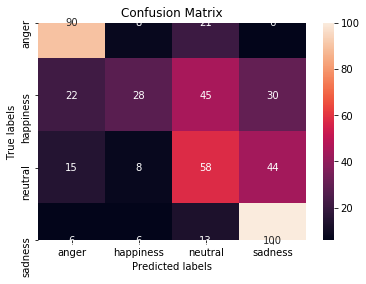

 61%|██████    | 36/59 [5:01:16<3:10:31, 497.01s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.72      0.70       125
   happiness       0.56      0.22      0.32       125
     neutral       0.42      0.46      0.44       125
     sadness       0.56      0.80      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.55      0.55      0.53       500
weighted avg       0.55      0.55      0.53       500
 

Train Epoch: 37 [0/3760 (0%)]	Loss: 1.131862

Train Epoch: 37 [640/3760 (17%)]	Loss: 0.953871

Train Epoch: 37 [1280/3760 (34%)]	Loss: 0.985404

Train Epoch: 37 [1920/3760 (51%)]	Loss: 1.056404

Train Epoch: 37 [2560/3760 (68%)]	Loss: 1.092905

Train Epoch: 37 [3200/3760 (85%)]	Loss: 0.982446


Train set: Average loss: 0.0159


Train Accuracy: 2120/3760 (56%)


Test set: Average loss: 0.0164, Accuracy: 278/500 (56%)



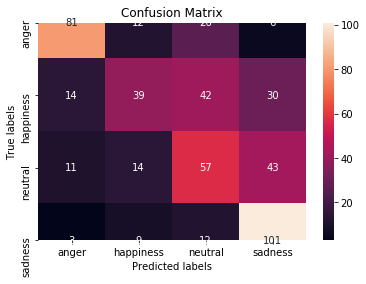

 63%|██████▎   | 37/59 [5:09:33<3:02:14, 497.00s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.74      0.65      0.69       125
   happiness       0.53      0.31      0.39       125
     neutral       0.42      0.46      0.44       125
     sadness       0.56      0.81      0.66       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.56      0.56      0.55       500
weighted avg       0.56      0.56      0.55       500
 

Train Epoch: 38 [0/3760 (0%)]	Loss: 0.992633

Train Epoch: 38 [640/3760 (17%)]	Loss: 1.036393

Train Epoch: 38 [1280/3760 (34%)]	Loss: 1.005430

Train Epoch: 38 [1920/3760 (51%)]	Loss: 0.962162

Train Epoch: 38 [2560/3760 (68%)]	Loss: 0.989917

Train Epoch: 38 [3200/3760 (85%)]	Loss: 1.006322


Train set: Average loss: 0.0158


Train Accuracy: 2143/3760 (57%)


Test set: Average loss: 0.0163, Accuracy: 277/500 (55%)



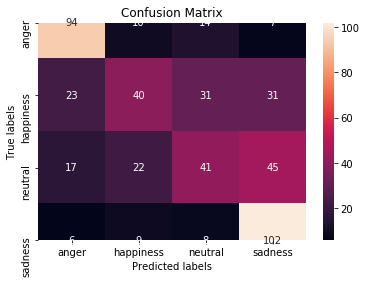

 64%|██████▍   | 38/59 [5:17:49<2:53:54, 496.88s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.67      0.75      0.71       125
   happiness       0.49      0.32      0.39       125
     neutral       0.44      0.33      0.37       125
     sadness       0.55      0.82      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.53       500
weighted avg       0.54      0.55      0.53       500
 

Train Epoch: 39 [0/3760 (0%)]	Loss: 0.992362

Train Epoch: 39 [640/3760 (17%)]	Loss: 1.089843

Train Epoch: 39 [1280/3760 (34%)]	Loss: 1.117919

Train Epoch: 39 [1920/3760 (51%)]	Loss: 1.007140

Train Epoch: 39 [2560/3760 (68%)]	Loss: 1.114547

Train Epoch: 39 [3200/3760 (85%)]	Loss: 1.028818


Train set: Average loss: 0.0160


Train Accuracy: 2121/3760 (56%)


Test set: Average loss: 0.0162, Accuracy: 278/500 (56%)



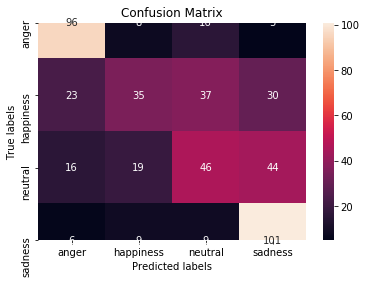

 66%|██████▌   | 39/59 [5:26:06<2:45:38, 496.93s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.77      0.72       125
   happiness       0.49      0.28      0.36       125
     neutral       0.43      0.37      0.39       125
     sadness       0.56      0.81      0.66       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.54      0.56      0.53       500
weighted avg       0.54      0.56      0.53       500
 

Train Epoch: 40 [0/3760 (0%)]	Loss: 1.114242

Train Epoch: 40 [640/3760 (17%)]	Loss: 0.886634

Train Epoch: 40 [1280/3760 (34%)]	Loss: 0.984811

Train Epoch: 40 [1920/3760 (51%)]	Loss: 0.996616

Train Epoch: 40 [2560/3760 (68%)]	Loss: 1.143694

Train Epoch: 40 [3200/3760 (85%)]	Loss: 0.964190


Train set: Average loss: 0.0159


Train Accuracy: 2129/3760 (57%)


Test set: Average loss: 0.0164, Accuracy: 272/500 (54%)



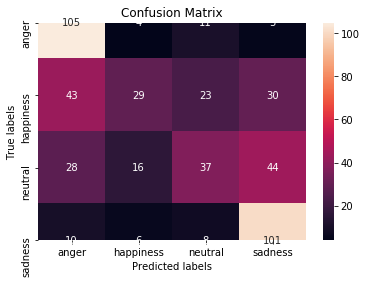

 68%|██████▊   | 40/59 [5:34:23<2:37:22, 496.99s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.56      0.84      0.68       125
   happiness       0.53      0.23      0.32       125
     neutral       0.47      0.30      0.36       125
     sadness       0.56      0.81      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.53      0.54      0.51       500
weighted avg       0.53      0.54      0.51       500
 

Train Epoch: 41 [0/3760 (0%)]	Loss: 0.893291

Train Epoch: 41 [640/3760 (17%)]	Loss: 1.040214

Train Epoch: 41 [1280/3760 (34%)]	Loss: 1.092229

Train Epoch: 41 [1920/3760 (51%)]	Loss: 0.984317

Train Epoch: 41 [2560/3760 (68%)]	Loss: 0.980482

Train Epoch: 41 [3200/3760 (85%)]	Loss: 0.994053


Train set: Average loss: 0.0158


Train Accuracy: 2137/3760 (57%)


Test set: Average loss: 0.0162, Accuracy: 277/500 (55%)



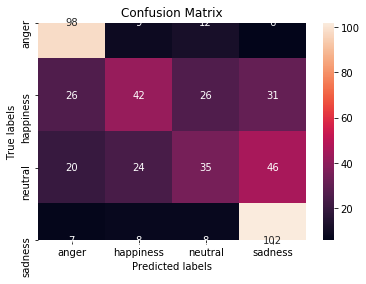

 69%|██████▉   | 41/59 [5:42:41<2:29:06, 497.05s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.78      0.71       125
   happiness       0.51      0.34      0.40       125
     neutral       0.43      0.28      0.34       125
     sadness       0.55      0.82      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.53      0.55      0.53       500
weighted avg       0.53      0.55      0.53       500
 

Train Epoch: 42 [0/3760 (0%)]	Loss: 0.917191

Train Epoch: 42 [640/3760 (17%)]	Loss: 1.022843

Train Epoch: 42 [1280/3760 (34%)]	Loss: 0.930577

Train Epoch: 42 [1920/3760 (51%)]	Loss: 0.963515

Train Epoch: 42 [2560/3760 (68%)]	Loss: 1.113558

Train Epoch: 42 [3200/3760 (85%)]	Loss: 0.913163


Train set: Average loss: 0.0159


Train Accuracy: 2147/3760 (57%)


Test set: Average loss: 0.0162, Accuracy: 280/500 (56%)



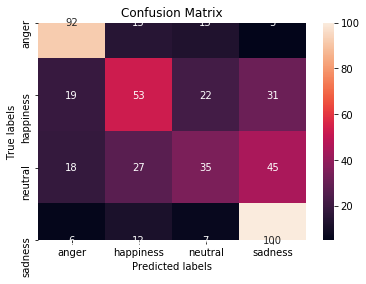

 71%|███████   | 42/59 [5:50:57<2:20:49, 497.01s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.74      0.71       125
   happiness       0.50      0.42      0.46       125
     neutral       0.45      0.28      0.35       125
     sadness       0.55      0.80      0.65       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 43 [0/3760 (0%)]	Loss: 0.934768

Train Epoch: 43 [640/3760 (17%)]	Loss: 1.055230

Train Epoch: 43 [1280/3760 (34%)]	Loss: 0.930945

Train Epoch: 43 [1920/3760 (51%)]	Loss: 1.050127

Train Epoch: 43 [2560/3760 (68%)]	Loss: 1.000749

Train Epoch: 43 [3200/3760 (85%)]	Loss: 0.968017


Train set: Average loss: 0.0159


Train Accuracy: 2109/3760 (56%)


Test set: Average loss: 0.0162, Accuracy: 281/500 (56%)



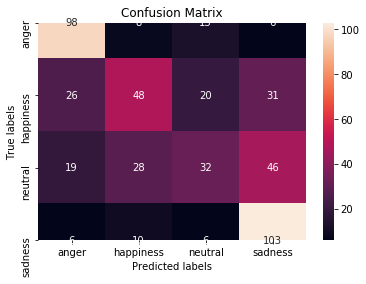

 73%|███████▎  | 43/59 [5:59:27<2:13:30, 500.68s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.78      0.72       125
   happiness       0.51      0.38      0.44       125
     neutral       0.45      0.26      0.33       125
     sadness       0.55      0.82      0.66       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.54      0.56      0.54       500
weighted avg       0.54      0.56      0.54       500
 

Train Epoch: 44 [0/3760 (0%)]	Loss: 1.019203

Train Epoch: 44 [640/3760 (17%)]	Loss: 1.025223

Train Epoch: 44 [1280/3760 (34%)]	Loss: 1.077984

Train Epoch: 44 [1920/3760 (51%)]	Loss: 0.959309

Train Epoch: 44 [2560/3760 (68%)]	Loss: 0.923933

Train Epoch: 44 [3200/3760 (85%)]	Loss: 0.977764


Train set: Average loss: 0.0157


Train Accuracy: 2148/3760 (57%)


Test set: Average loss: 0.0163, Accuracy: 274/500 (55%)



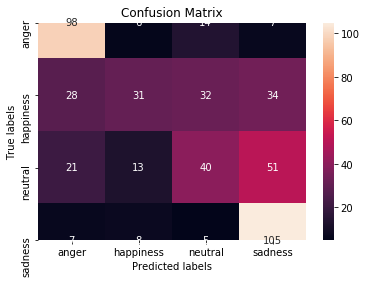

 75%|███████▍  | 44/59 [6:07:43<2:04:49, 499.30s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.78      0.70       125
   happiness       0.53      0.25      0.34       125
     neutral       0.44      0.32      0.37       125
     sadness       0.53      0.84      0.65       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.52       500
weighted avg       0.54      0.55      0.52       500
 

Train Epoch: 45 [0/3760 (0%)]	Loss: 0.957337

Train Epoch: 45 [640/3760 (17%)]	Loss: 0.990426

Train Epoch: 45 [1280/3760 (34%)]	Loss: 0.979853

Train Epoch: 45 [1920/3760 (51%)]	Loss: 1.167787

Train Epoch: 45 [2560/3760 (68%)]	Loss: 0.977494

Train Epoch: 45 [3200/3760 (85%)]	Loss: 1.096089


Train set: Average loss: 0.0159


Train Accuracy: 2129/3760 (57%)


Test set: Average loss: 0.0161, Accuracy: 281/500 (56%)



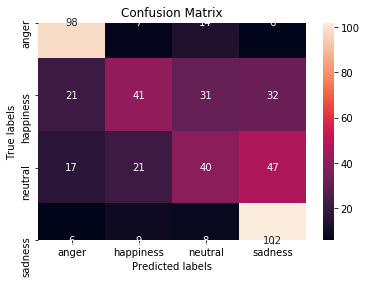

 76%|███████▋  | 45/59 [6:15:59<1:56:15, 498.28s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.69      0.78      0.73       125
   happiness       0.53      0.33      0.40       125
     neutral       0.43      0.32      0.37       125
     sadness       0.55      0.82      0.65       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 46 [0/3760 (0%)]	Loss: 1.034772

Train Epoch: 46 [640/3760 (17%)]	Loss: 0.972532

Train Epoch: 46 [1280/3760 (34%)]	Loss: 0.836448

Train Epoch: 46 [1920/3760 (51%)]	Loss: 0.931689

Train Epoch: 46 [2560/3760 (68%)]	Loss: 0.878705

Train Epoch: 46 [3200/3760 (85%)]	Loss: 0.968819


Train set: Average loss: 0.0155


Train Accuracy: 2187/3760 (58%)


Test set: Average loss: 0.0161, Accuracy: 280/500 (56%)



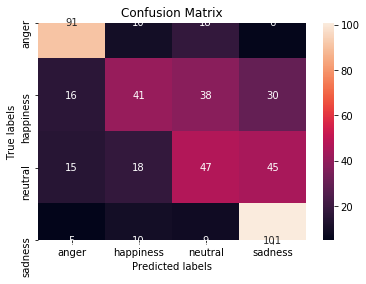

 78%|███████▊  | 46/59 [6:24:15<1:47:50, 497.71s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.72      0.73      0.72       125
   happiness       0.52      0.33      0.40       125
     neutral       0.42      0.38      0.40       125
     sadness       0.55      0.81      0.66       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 47 [0/3760 (0%)]	Loss: 1.005286

Train Epoch: 47 [640/3760 (17%)]	Loss: 0.764483

Train Epoch: 47 [1280/3760 (34%)]	Loss: 1.048732

Train Epoch: 47 [1920/3760 (51%)]	Loss: 1.031946

Train Epoch: 47 [2560/3760 (68%)]	Loss: 0.962246

Train Epoch: 47 [3200/3760 (85%)]	Loss: 0.993636


Train set: Average loss: 0.0157


Train Accuracy: 2162/3760 (58%)


Test set: Average loss: 0.0162, Accuracy: 272/500 (54%)



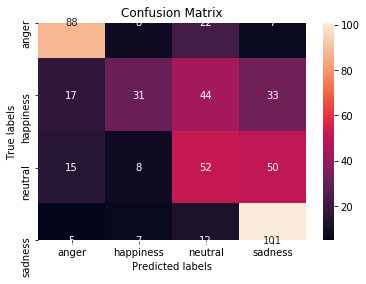

 80%|███████▉  | 47/59 [6:32:31<1:39:26, 497.20s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.70      0.70      0.70       125
   happiness       0.57      0.25      0.35       125
     neutral       0.40      0.42      0.41       125
     sadness       0.53      0.81      0.64       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.55      0.54      0.52       500
weighted avg       0.55      0.54      0.52       500
 

Train Epoch: 48 [0/3760 (0%)]	Loss: 0.952770

Train Epoch: 48 [640/3760 (17%)]	Loss: 0.960748

Train Epoch: 48 [1280/3760 (34%)]	Loss: 1.051559

Train Epoch: 48 [1920/3760 (51%)]	Loss: 0.993774

Train Epoch: 48 [2560/3760 (68%)]	Loss: 1.128456

Train Epoch: 48 [3200/3760 (85%)]	Loss: 1.025212


Train set: Average loss: 0.0157


Train Accuracy: 2170/3760 (58%)


Test set: Average loss: 0.0161, Accuracy: 276/500 (55%)



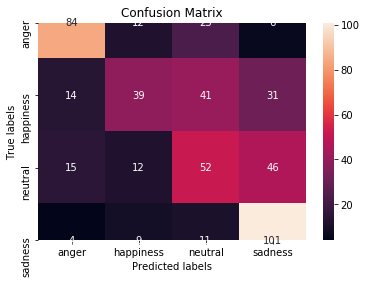

 81%|████████▏ | 48/59 [6:40:47<1:31:06, 496.93s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.72      0.67      0.69       125
   happiness       0.54      0.31      0.40       125
     neutral       0.41      0.42      0.41       125
     sadness       0.55      0.81      0.65       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.55      0.55      0.54       500
weighted avg       0.55      0.55      0.54       500
 

Train Epoch: 49 [0/3760 (0%)]	Loss: 1.098065

Train Epoch: 49 [640/3760 (17%)]	Loss: 1.037104

Train Epoch: 49 [1280/3760 (34%)]	Loss: 1.019866

Train Epoch: 49 [1920/3760 (51%)]	Loss: 0.914438

Train Epoch: 49 [2560/3760 (68%)]	Loss: 0.995490

Train Epoch: 49 [3200/3760 (85%)]	Loss: 1.162697


Train set: Average loss: 0.0156


Train Accuracy: 2219/3760 (59%)


Test set: Average loss: 0.0161, Accuracy: 284/500 (57%)



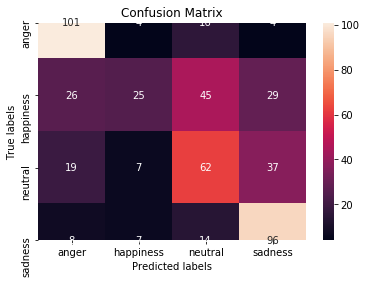

 83%|████████▎ | 49/59 [6:49:03<1:22:45, 496.57s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.81      0.72       125
   happiness       0.58      0.20      0.30       125
     neutral       0.45      0.50      0.47       125
     sadness       0.58      0.77      0.66       125

   micro avg       0.57      0.57      0.57       500
   macro avg       0.57      0.57      0.54       500
weighted avg       0.57      0.57      0.54       500
 

Train Epoch: 50 [0/3760 (0%)]	Loss: 0.968441

Train Epoch: 50 [640/3760 (17%)]	Loss: 1.060327

Train Epoch: 50 [1280/3760 (34%)]	Loss: 1.123080

Train Epoch: 50 [1920/3760 (51%)]	Loss: 0.935102

Train Epoch: 50 [2560/3760 (68%)]	Loss: 1.027842

Train Epoch: 50 [3200/3760 (85%)]	Loss: 0.997640


Train set: Average loss: 0.0156


Train Accuracy: 2150/3760 (57%)


Test set: Average loss: 0.0160, Accuracy: 283/500 (57%)



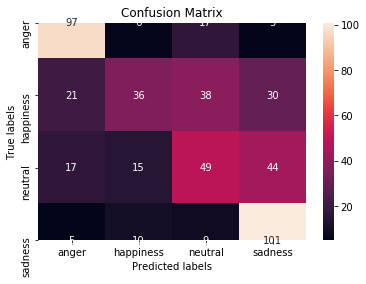

 85%|████████▍ | 50/59 [6:57:19<1:14:28, 496.45s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.69      0.78      0.73       125
   happiness       0.54      0.29      0.37       125
     neutral       0.43      0.39      0.41       125
     sadness       0.56      0.81      0.66       125

   micro avg       0.57      0.57      0.57       500
   macro avg       0.56      0.57      0.55       500
weighted avg       0.56      0.57      0.55       500
 

Train Epoch: 51 [0/3760 (0%)]	Loss: 1.047740

Train Epoch: 51 [640/3760 (17%)]	Loss: 0.943921

Train Epoch: 51 [1280/3760 (34%)]	Loss: 0.850730

Train Epoch: 51 [1920/3760 (51%)]	Loss: 0.927843

Train Epoch: 51 [2560/3760 (68%)]	Loss: 0.864024

Train Epoch: 51 [3200/3760 (85%)]	Loss: 0.914080


Train set: Average loss: 0.0155


Train Accuracy: 2196/3760 (58%)


Test set: Average loss: 0.0160, Accuracy: 279/500 (56%)



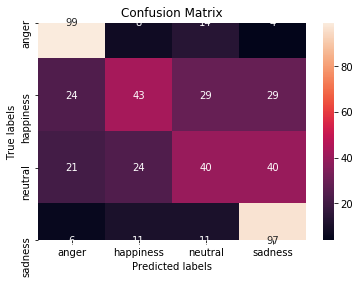

 86%|████████▋ | 51/59 [7:05:35<1:06:09, 496.24s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.79      0.72       125
   happiness       0.50      0.34      0.41       125
     neutral       0.43      0.32      0.37       125
     sadness       0.57      0.78      0.66       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.54      0.56      0.54       500
weighted avg       0.54      0.56      0.54       500
 

Train Epoch: 52 [0/3760 (0%)]	Loss: 1.026624

Train Epoch: 52 [640/3760 (17%)]	Loss: 0.949355

Train Epoch: 52 [1280/3760 (34%)]	Loss: 0.902653

Train Epoch: 52 [1920/3760 (51%)]	Loss: 1.029953

Train Epoch: 52 [2560/3760 (68%)]	Loss: 1.197442

Train Epoch: 52 [3200/3760 (85%)]	Loss: 1.061705


Train set: Average loss: 0.0156


Train Accuracy: 2166/3760 (58%)


Test set: Average loss: 0.0161, Accuracy: 284/500 (57%)



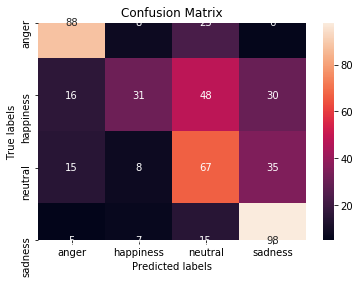

 88%|████████▊ | 52/59 [7:13:51<57:52, 496.05s/it]  


 Classification Report 
               precision    recall  f1-score   support

       anger       0.71      0.70      0.71       125
   happiness       0.57      0.25      0.35       125
     neutral       0.44      0.54      0.48       125
     sadness       0.58      0.78      0.67       125

   micro avg       0.57      0.57      0.57       500
   macro avg       0.58      0.57      0.55       500
weighted avg       0.58      0.57      0.55       500
 

Train Epoch: 53 [0/3760 (0%)]	Loss: 1.081211

Train Epoch: 53 [640/3760 (17%)]	Loss: 0.965722

Train Epoch: 53 [1280/3760 (34%)]	Loss: 1.038098

Train Epoch: 53 [1920/3760 (51%)]	Loss: 1.040346

Train Epoch: 53 [2560/3760 (68%)]	Loss: 0.918959

Train Epoch: 53 [3200/3760 (85%)]	Loss: 1.006110


Train set: Average loss: 0.0155


Train Accuracy: 2210/3760 (59%)


Test set: Average loss: 0.0160, Accuracy: 274/500 (55%)



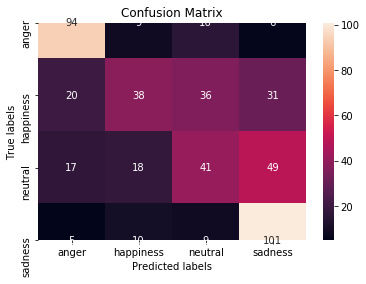

 90%|████████▉ | 53/59 [7:22:07<49:36, 496.02s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.69      0.75      0.72       125
   happiness       0.51      0.30      0.38       125
     neutral       0.40      0.33      0.36       125
     sadness       0.54      0.81      0.65       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.53      0.55      0.53       500
weighted avg       0.53      0.55      0.53       500
 

Train Epoch: 54 [0/3760 (0%)]	Loss: 0.958075

Train Epoch: 54 [640/3760 (17%)]	Loss: 1.013402

Train Epoch: 54 [1280/3760 (34%)]	Loss: 0.928990

Train Epoch: 54 [1920/3760 (51%)]	Loss: 0.900462

Train Epoch: 54 [2560/3760 (68%)]	Loss: 1.063734

Train Epoch: 54 [3200/3760 (85%)]	Loss: 0.973894


Train set: Average loss: 0.0153


Train Accuracy: 2220/3760 (59%)


Test set: Average loss: 0.0161, Accuracy: 276/500 (55%)



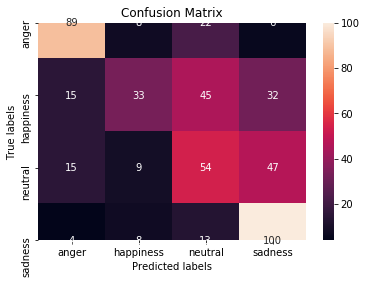

 92%|█████████▏| 54/59 [7:30:23<41:19, 495.99s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.72      0.71      0.72       125
   happiness       0.57      0.26      0.36       125
     neutral       0.40      0.43      0.42       125
     sadness       0.54      0.80      0.65       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.56      0.55      0.54       500
weighted avg       0.56      0.55      0.54       500
 

Train Epoch: 55 [0/3760 (0%)]	Loss: 1.032981

Train Epoch: 55 [640/3760 (17%)]	Loss: 0.988406

Train Epoch: 55 [1280/3760 (34%)]	Loss: 0.848835

Train Epoch: 55 [1920/3760 (51%)]	Loss: 1.047583

Train Epoch: 55 [2560/3760 (68%)]	Loss: 0.909796

Train Epoch: 55 [3200/3760 (85%)]	Loss: 0.940864


Train set: Average loss: 0.0155


Train Accuracy: 2172/3760 (58%)


Test set: Average loss: 0.0161, Accuracy: 280/500 (56%)



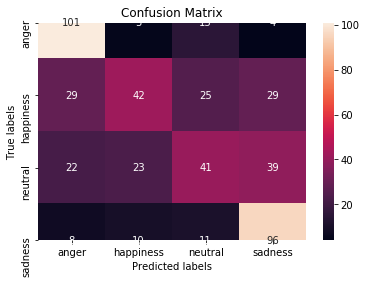

 93%|█████████▎| 55/59 [7:38:38<33:03, 495.95s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.81      0.71       125
   happiness       0.53      0.34      0.41       125
     neutral       0.45      0.33      0.38       125
     sadness       0.57      0.77      0.66       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.54      0.56      0.54       500
weighted avg       0.54      0.56      0.54       500
 

Train Epoch: 56 [0/3760 (0%)]	Loss: 1.100611

Train Epoch: 56 [640/3760 (17%)]	Loss: 1.107684

Train Epoch: 56 [1280/3760 (34%)]	Loss: 0.983850

Train Epoch: 56 [1920/3760 (51%)]	Loss: 0.861525

Train Epoch: 56 [2560/3760 (68%)]	Loss: 0.951916

Train Epoch: 56 [3200/3760 (85%)]	Loss: 0.909478


Train set: Average loss: 0.0152


Train Accuracy: 2233/3760 (59%)


Test set: Average loss: 0.0161, Accuracy: 277/500 (55%)



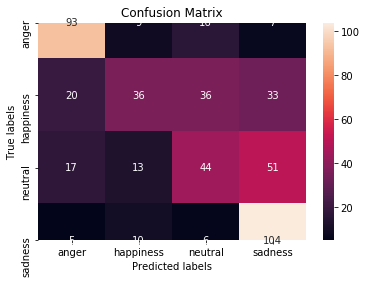

 95%|█████████▍| 56/59 [7:46:53<24:46, 495.60s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.69      0.74      0.72       125
   happiness       0.53      0.29      0.37       125
     neutral       0.43      0.35      0.39       125
     sadness       0.53      0.83      0.65       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.55      0.55      0.53       500
weighted avg       0.55      0.55      0.53       500
 

Train Epoch: 57 [0/3760 (0%)]	Loss: 0.969429

Train Epoch: 57 [640/3760 (17%)]	Loss: 0.934787

Train Epoch: 57 [1280/3760 (34%)]	Loss: 1.003392

Train Epoch: 57 [1920/3760 (51%)]	Loss: 0.901294

Train Epoch: 57 [2560/3760 (68%)]	Loss: 1.111114

Train Epoch: 57 [3200/3760 (85%)]	Loss: 1.126018


Train set: Average loss: 0.0153


Train Accuracy: 2191/3760 (58%)


Test set: Average loss: 0.0160, Accuracy: 278/500 (56%)



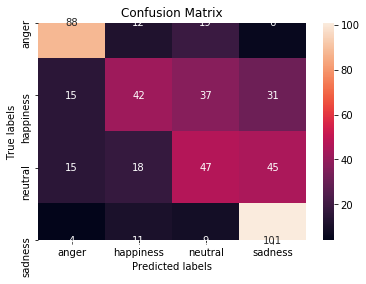

 97%|█████████▋| 57/59 [7:55:08<16:30, 495.27s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.72      0.70      0.71       125
   happiness       0.51      0.34      0.40       125
     neutral       0.42      0.38      0.40       125
     sadness       0.55      0.81      0.66       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 58 [0/3760 (0%)]	Loss: 1.008504

Train Epoch: 58 [640/3760 (17%)]	Loss: 0.888859

Train Epoch: 58 [1280/3760 (34%)]	Loss: 0.939672

Train Epoch: 58 [1920/3760 (51%)]	Loss: 0.942308

Train Epoch: 58 [2560/3760 (68%)]	Loss: 0.934319

Train Epoch: 58 [3200/3760 (85%)]	Loss: 0.971760


Train set: Average loss: 0.0153


Train Accuracy: 2199/3760 (58%)


Test set: Average loss: 0.0159, Accuracy: 280/500 (56%)



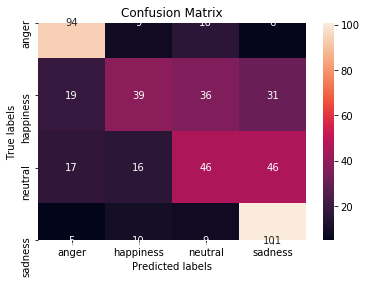

 98%|█████████▊| 58/59 [8:03:22<08:14, 494.97s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.70      0.75      0.72       125
   happiness       0.53      0.31      0.39       125
     neutral       0.43      0.37      0.40       125
     sadness       0.55      0.81      0.65       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 59 [0/3760 (0%)]	Loss: 0.953078

Train Epoch: 59 [640/3760 (17%)]	Loss: 1.058823

Train Epoch: 59 [1280/3760 (34%)]	Loss: 0.875604

Train Epoch: 59 [1920/3760 (51%)]	Loss: 1.044844

Train Epoch: 59 [2560/3760 (68%)]	Loss: 1.032415

Train Epoch: 59 [3200/3760 (85%)]	Loss: 1.022948


Train set: Average loss: 0.0152


Train Accuracy: 2210/3760 (59%)


Test set: Average loss: 0.0160, Accuracy: 281/500 (56%)



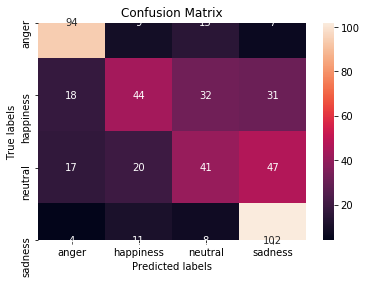

100%|██████████| 59/59 [8:11:36<00:00, 499.94s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.71      0.75      0.73       125
   happiness       0.52      0.35      0.42       125
     neutral       0.43      0.33      0.37       125
     sadness       0.55      0.82      0.65       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 



In [25]:
from tqdm import tqdm
history = []
n_epoch = 60
for epoch in tqdm(range(1, n_epoch)):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
#     plateau_scheduler.step(test_loss)
    
    history.append([train_loss, train_acc, test_loss, test_acc])

In [26]:
history_df = pd.DataFrame(history, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [27]:
history_df["epoch"] = [x for x in range(1, n_epoch)]

In [28]:
history_df

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.021688,28,0.021256,46,1
1,0.020927,35,0.020657,46,2
2,0.020377,40,0.020131,49,3
3,0.020004,42,0.019650,50,4
4,0.019674,44,0.019289,49,5
5,0.019199,45,0.018881,52,6
6,0.018825,47,0.018555,50,7
7,0.018474,47,0.018382,51,8
8,0.018372,48,0.018098,53,9
9,0.018191,48,0.017971,52,10


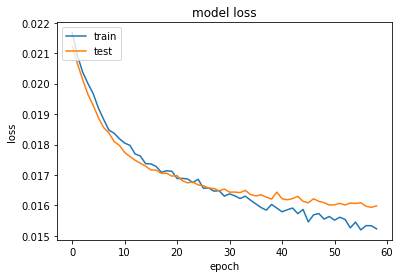

In [29]:
plt.plot(history_df.train_loss)
plt.plot(history_df.test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

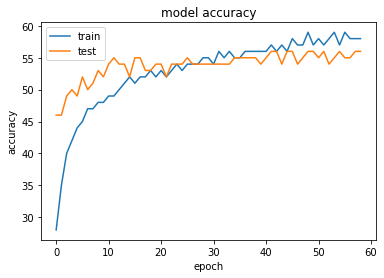

In [30]:
plt.plot(history_df.train_acc)
plt.plot(history_df.test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()